In [24]:
from MH import Metropolis_Hastings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [25]:
# define rosenbrock function
def rosenbrock(x):
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [26]:
# define the probability density function
def pdf_rosenbrock(x):
    return np.exp(-rosenbrock(x))

In [27]:
# set limits for the x and y axis
xlimits = [-1, 3]
ylimits = [-1, 3]

(400, 400)


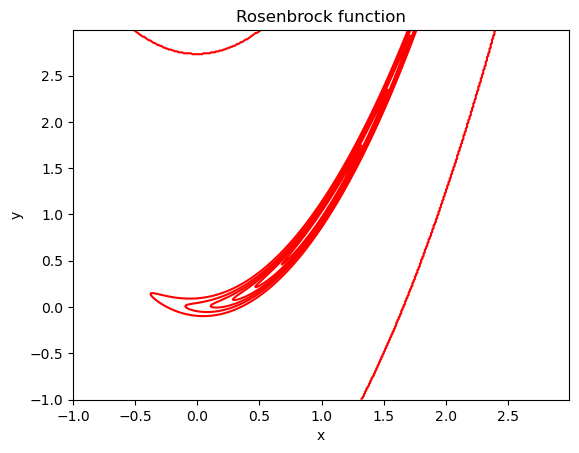

In [28]:
# plot the 2 dimensional rosenbrock function
pts_x = np.arange(xlimits[0], xlimits[1], 0.01)
pts_y = np.arange(ylimits[0], ylimits[1], 0.01)
X, Y = np.meshgrid(pts_x, pts_y)

# convert X and Y to a 2D array
Z = pdf_rosenbrock(np.array([X,Y]))
print (Z.shape)

fig, ax = plt.subplots()
ax.contour(X, Y, Z, colors='r', levels = 6)
ax.set_title('Rosenbrock function')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [29]:
# Save X, Y and Z to a pandas dataframe
df = pd.DataFrame({'X': X.ravel(), 'Y': Y.ravel(), 'Z': Z.ravel()})

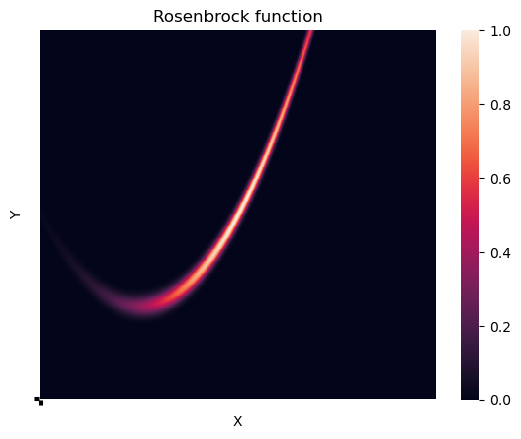

In [30]:
# plot the 2D rosenbrock function using seaborn
# plot the heatmap
sns.heatmap(df.pivot(index="Y", columns="X", values="Z"))
plt.title('Rosenbrock function')
# revserse the y-axis to match the previous plot
plt.gca().invert_yaxis()
plt.xticks(np.arange(xlimits[0], xlimits[1], 1))
plt.yticks(np.arange(ylimits[0], ylimits[1], 1))
plt.show()

## Metropolis-Hastings Algorithm

In [31]:
size_of_chain = 100000
chain, acceptance = Metropolis_Hastings(target_func=pdf_rosenbrock, N=size_of_chain)

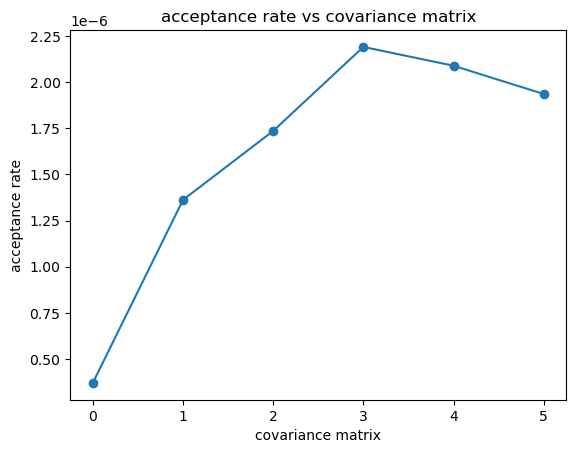

In [32]:
#search accross the covariance matrix space to find the best acceptance rate
acceptance_rates = []
cov_matrix_list = [
    [[1,0],[0,1]],
    [[0.1,0],[0,0.1]],
    [[0.1,0.05],[0.05,0.1]],
    [[0.1,0.08],[0.08,0.1]],
    [[0.1,0.075],[0.075,0.1]],
    [[0.08,0.06],[0.06,0.08]],
]

for i, cov_matrix in enumerate(cov_matrix_list):
    chain, acceptance = Metropolis_Hastings(target_func=pdf_rosenbrock, N=size_of_chain, cov_matrix=cov_matrix)
    acceptance_rates.append(acceptance/size_of_chain)
    
# plot the acceptance rate vs covariance matrix
plt.plot(range(len(cov_matrix_list)), acceptance_rates, 'o-')
plt.xlabel('covariance matrix')
plt.ylabel('acceptance rate')
plt.title('acceptance rate vs covariance matrix')
plt.show()


In [33]:
# create a dataframe from the chain
df = pd.DataFrame(chain, columns=['x', 'y'])

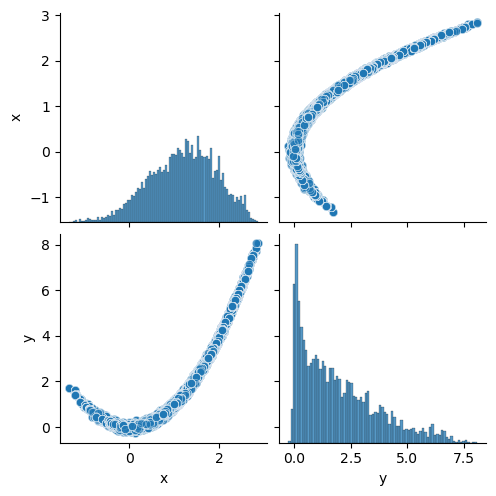

In [34]:
# plot the corner plot
sns.pairplot(df, markers='o', plot_kws={'alpha': 0.5})
plt.show()

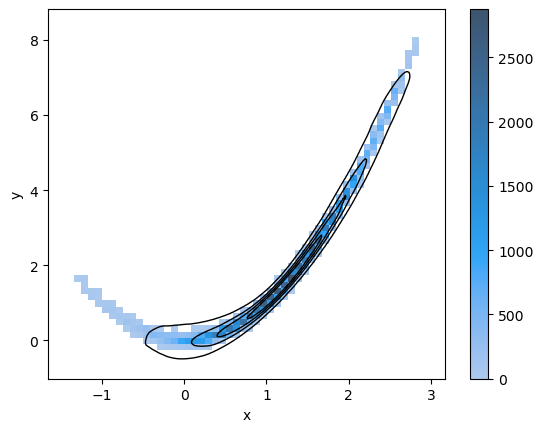

In [35]:
# plot density plot
sns.histplot(df, x='x', y='y', bins=50, cbar=True)
# Add contour lines
sns.kdeplot(df ,x='x', y='y', levels=5, colors='k', linewidths=1)
plt.show()

In [36]:
# investiagate the mean and standard deviation of the chain
chain_abs = [np.linalg.norm(vector) for vector in chain]
print ("Expected Value of |x| " ,np.mean(chain_abs, axis=0))
print ("Uncertainty in |x|", np.std(chain_abs, axis=0))

Expected Value of |x|  2.338542204030934
Uncertainty in |x| 1.7838173717073962


## Numerical Integration using Simpson's rule

In [37]:
# define the unnormalised pdf_rosenbrock(x) to integrate
def f(x):
    return sum(pdf_rosenbrock(xi) for xi in x)

# define the unnormalised |x| * pdf_rosenbrock(x) to integrate
def Ex(x):
    return sum(np.linalg.norm(xi) * pdf_rosenbrock(xi) for xi in x)


In [38]:
def x_abs_pdf(x):
    return np.linalg.norm(x) * pdf_rosenbrock(x)

In [39]:
def simpson_integration(func,a,b,N):
    dx=(b-a)/N
    I=0
    for i in range (1,N):
        if i%2 == 1:
            I+=4*func(a+i*dx)
        else:
            I+=2*func(a+i*dx)
    I=(func(a)+I+func(b))*dx/3
    return I

def simpson_integration_2D(func,a,b,N):
    dx=(b[0]-a[0])/N
    dy=(b[1]-a[1])/N
    I=0
    for i in range (1,N):
        for j in range (1,N):
            x = np.array([a[0]+i*dx,a[1]+j*dy])
            if i%2 == 1:
                if j%2 == 1:
                    I+=16*func(x)
                else:
                    I+=8*func(x)
            else:
                if j%2 == 1:
                    I+=8*func(x)
                else:
                    I+=4*func(x)
    I=(func(a)+I+func(b))*dx*dy/9
    return I

In [40]:
# Test Simpson's rule on a normalised Gaussian
def gaussian_pdf (x, mean = np.array([0,0]), sigma = np.array([[0.1,0.01],[0.01, 0.1]])):
    d = len(mean)
    # return the probability of x given mu and sigma
    return np.exp(-0.5 * (x - mean).T @ np.linalg.inv(cov_matrix) @ (x - mean)) / (2 * np.pi)**(d/2) / np.sqrt(np.linalg.det(cov_matrix))

I = simpson_integration_2D(gaussian_pdf, np.array([-10,-10]), np.array([5,5]), 1000)
print (I)
assert np.isclose(I, 1, atol=1e-6)


0.999999999999952


In [41]:
# number of points in each dimension
n = 5000

# define the limits of the integration
limits = xlimits 

# define the dimension of the space
d = 2

# create a grid of points
X = [np.linspace(limits[0], limits[1], n) for i in range(d)]
x = np.array([[x, y] for x in X[1] for y in X[0]])

# evaluate the function at each point
f_x = simpson_integration_2D(pdf_rosenbrock, np.array([-1,-1]), np.array([3,3]), n)

# evaluate the |x| * pdf(x) at each point
E_x = simpson_integration_2D(x_abs_pdf, np.array([-1,-1]), np.array([3,3]), n)

# normalise the integral
integral2 = E_x/f_x

print (integral2)


1.3234881592748577
